In [332]:

import pandas as pd
import json
import numpy as np
import matplotlib.pyplot as plt
import csv

spending_data = pd.read_csv("data/yapikredi_formatted/yapikredi_spending_data.csv")
weather_data = json.load(open("data/weather_data_false.json"))

daily_spending = spending_data.groupby('date')['amount'].sum().reset_index()

temp_data = pd.DataFrame({
    'date': weather_data['daily']['time'],
    'temp_mean': weather_data['daily']['temperature_2m_mean'],
    'rain_sum': weather_data['daily']['rain_sum'],
    'snow_sum': weather_data['daily']['snowfall_sum']
})

# Merge spending and temperature data
merged_data = pd.merge(daily_spending, temp_data, on='date')



In [305]:
# outlier analysis
# get top 10 individual transactions with amounts and descriptions
top_spending = spending_data[['description', 'amount']].sort_values('amount', ascending=False)
print(top_spending.head(10))


# empty dataframe to store the new spending data
new_spending_data = pd.DataFrame()

# Filter the data, remove the data including "V.D." (taxes), "APPLE" (outlier, phone purchase)
for index, row in spending_data.iterrows():
    if not ("V.D." in row['description'] or "APPLE" in row['description'] or "AJET" in row['description'] or "Spotify" in row['description']):
        # dataframe has no attribute append, so use concat
        new_spending_data = pd.concat([new_spending_data, row.to_frame().T], ignore_index=True)

# save the data back to csv
new_spending_data.to_csv("data/yapikredi_formatted/yapikredi_spending_data.csv", index=False)


                           description    amount
448                    BEYMEN ISTANBUL  14659.99
302        FENİX FENİX YALIKAVAK MUĞLA   7920.00
327    FAPEL GIDA İNŞAAT OTOMOİSTANBUL   4980.00
337        DEDECAN RESTAURANT İSTANBUL   2395.00
339  A-101 9935 H050 A101 METRİSTANBUL   1963.15
390    ATLI OTOMOTİV NAK.SAN.TİSTANBUL   1946.97
47                 EFDAL GIDA ISTANBUL   1650.00
466  MİGROS 5M VİAPORT AVM İSTİSTANBUL   1611.96
26              OVERSEA TRADE ISTANBUL   1318.00
307       BODRUM BELEDIYESI GIDA MUGLA    996.00


In [306]:
# outlier analysis

# merchant analysis
merchant_spending = spending_data.groupby('description')['amount'].agg(['sum', 'count', 'mean']).sort_values('sum', ascending=False)
print("\nTop 10 Merchants by Total Spending:")
print(merchant_spending.head(10))




Top 10 Merchants by Total Spending:
                                        sum  count          mean
description                                                     
BEYMEN ISTANBUL                    14659.99      1  14659.990000
SELF GIDA SANAYI VE TICISTANBUL    12087.00     68    177.750000
FENİX FENİX YALIKAVAK MUĞLA         7920.00      1   7920.000000
KUCUK EV SABANCI UNIVERISTANBUL     7664.00     56    136.857143
FAPEL GIDA İNŞAAT OTOMOİSTANBUL     4980.00      1   4980.000000
A-101 9935 H050 A101 METRİSTANBUL   2912.05      4    728.012500
ŞOK ŞOK 7036 İSTANBUL SABİSTANBUL   2842.45     24    118.435417
ATLI OTOMOTİV NAK.SAN.TİSTANBUL     2746.97      2   1373.485000
SABANCI ÜNİVERSİTESİ İSTANBUL       2714.50     32     84.828125
DEDECAN RESTAURANT İSTANBUL         2395.00      1   2395.000000


In [307]:
# Check duplicate data (same amount, same description, same date)
duplicate_data = spending_data[spending_data.duplicated(subset=['description', 'amount', 'date'])]
print(duplicate_data)

# looks like there are some duplicate transactions, 
# some of them are installments, no need to remove them
# some of them are actual transactions (something that I bought twice back to back)
#



     date                        description  amount
19     63    SELF GIDA SANAYI VE TICISTANBUL   170.0
111   106    İF PERFORMANCE HALL BEŞİSTANBUL   150.0
207   147    SELF GIDA SANAYI VE TICISTANBUL   190.0
222   154    SELF GIDA SANAYI VE TICISTANBUL   190.0
239   160    SELF GIDA SANAYI VE TICISTANBUL   215.0
290   202  PULLBEAR PULL BEAR MARMARİSTANBUL   450.0
291   202  PULLBEAR PULL BEAR MARMARİSTANBUL   450.0
410   278    İŞBİLİR GIDA İLETİŞİM İİSTANBUL   600.0


In [308]:
"""
So, I realised something here, previously I was using the `mean` method over my total spending per day on my merged data,
which is not correct, since in my merged data, the days with no spending at all are not included,
and this makes the average spending per day wrong.

for example, if my data looks like this (lets say 5 days between 1,5):
(assume all the days have the same temperature, 13)
1, X restaurant, 50
1, K restaurant, 50
2, Y restaurant, 100
5, Z restaurant, 100

mean of the total spending for the days with temp 13 should be (100+100+100)/5 = 60, right?

but when I take the mean of the merged data, I would get 100, since it would only count the days with spending, so as a solution
I will add placeholder spending with 0 amount for the days with no spending, and then take the mean of the data, this way I will get the correct mean
"""


"""
I will not add placeholder spending for the interval 164 to 168 (inclusive), 
since I was abroad in this interval and I dont have the spending data for these days (I was only using cash in Egypt).

This way the missing dates wont affect the mean. (from the same reason in above comment)
"""
for i in range(58, 164):
    if i not in spending_data['date'].values:
        new_row = pd.DataFrame({'date': [i], 'description': ['NO SPENDING'], 'amount': [0]})
        spending_data = pd.concat([spending_data, new_row], ignore_index=True)
for i in range(169, 337):
    if i not in spending_data['date'].values:
        new_row = pd.DataFrame({'date': [i], 'description': ['NO SPENDING'], 'amount': [0]})
        spending_data = pd.concat([spending_data, new_row], ignore_index=True)

# sort by date
spending_data = spending_data.sort_values('date')

# save the data back to csv
spending_data.to_csv("data/yapikredi_formatted/yapikredi_spending_data.csv", index=False)

/var/folders/fh/0nm6v2n92gldyxd0b7h3725m0000gn/T/ipykernel_25685/786788302.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  temp_spending = merged_data.groupby('temp_bin')['amount'].mean().reset_index()


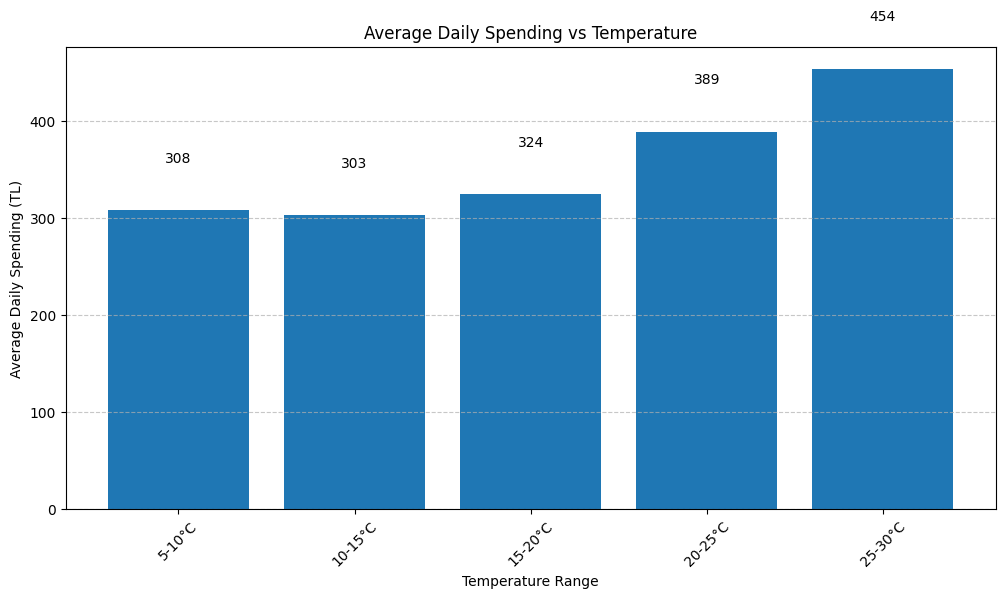

In [369]:

merged_data['temp_bin'] = pd.cut(merged_data['temp_mean'], 
                                bins=range(5, 35, 5),  # Creates bins: 5-10, 10-15, ..., 30-35
                                labels=[f'{i}-{i+5}°C' for i in range(5, 30, 5)])

# avg spending per temperature bin
temp_spending = merged_data.groupby('temp_bin')['amount'].mean().reset_index()

# plot
plt.figure(figsize=(12, 6))
plt.bar(temp_spending['temp_bin'], temp_spending['amount'])
plt.title('Average Daily Spending vs Temperature')
plt.xlabel('Temperature Range')
plt.ylabel('Average Daily Spending (TL)')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# labels
for i, v in enumerate(temp_spending['amount']):
    plt.text(i, v + 50, f'{v:.0f}', ha='center')    

plt.show()

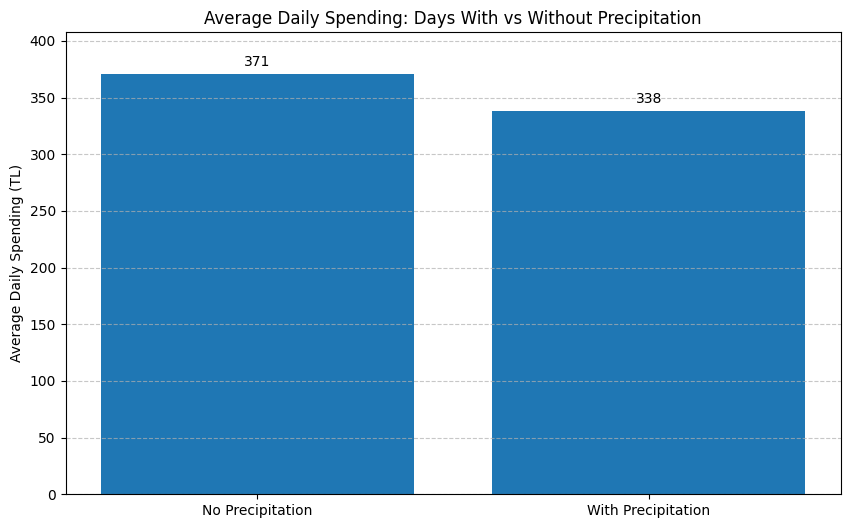


Average spending on days with vs without precipitation:
has_precipitation
False    370.565000
True     338.277661
Name: amount, dtype: float64

Percentage difference: -8.7% spending on days with precipitation


In [371]:
spending_data = pd.read_csv("data/yapikredi_formatted/yapikredi_spending_data.csv")
weather_data = json.load(open("data/weather_data_false.json"))

daily_spending = spending_data.groupby('date')['amount'].sum().reset_index()

temp_data = pd.DataFrame({
    'date': weather_data['daily']['time'],
    'temp_mean': weather_data['daily']['temperature_2m_mean'],
    'rain_sum': weather_data['daily']['rain_sum'],
    'snow_sum': weather_data['daily']['snowfall_sum']
})

# Merge spending and temperature data
merged_data = pd.merge(daily_spending, temp_data, on='date')



merged_data['has_precipitation'] = (merged_data['rain_sum'] > 0) | (merged_data['snow_sum'] > 0)

# calculate average spending for days with and without precipitation
precipitation_spending = merged_data.groupby('has_precipitation')['amount'].mean()

# plot
plt.figure(figsize=(10, 6))
bars = plt.bar(['No Precipitation', 'With Precipitation'], precipitation_spending)
plt.title('Average Daily Spending: Days With vs Without Precipitation')
plt.ylabel('Average Daily Spending (TL)')
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Adjust label position by increasing the vertical offset
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height * 1.02,  # Changed from height + 50 to height * 1.02
             f'{height:.0f}',
             ha='center')

# Add some padding to the top of the plot to ensure labels are visible
plt.margins(y=0.1)  # Add 10% padding to the top

plt.show()

print("\nAverage spending on days with vs without precipitation:")
print(precipitation_spending)

pct_difference = ((precipitation_spending[True] - precipitation_spending[False]) / precipitation_spending[False]) * 100
print(f"\nPercentage difference: {pct_difference:.1f}% spending on days with precipitation")




In [364]:
#PRint days with precipitation
for i, has_precipitation in enumerate(merged_data['has_precipitation']):
    if has_precipitation:
        print(f"Day {merged_data['date'][i]}: {merged_data['temp_mean'][i]:.1f}°C", end=" ")
        print(merged_data['amount'][i])


Day 62: 8.3°C 365.0
Day 64: 10.1°C 462.0
Day 65: 8.3°C 75.0
Day 67: 6.7°C 158.0
Day 68: 6.6°C 70.77
Day 71: 12.8°C 194.5
Day 72: 11.5°C 455.5
Day 73: 9.8°C 184.5
Day 74: 8.2°C 1242.68
Day 75: 7.6°C 800.05
Day 78: 10.1°C 247.25
Day 79: 6.5°C 68.0
Day 80: 5.9°C 315.25
Day 81: 6.1°C 68.0
Day 84: 10.6°C 267.75
Day 86: 14.4°C 0.0
Day 87: 16.3°C 490.0
Day 97: 12.6°C 0.0
Day 107: 20.6°C 1344.0
Day 108: 16.6°C 189.5
Day 109: 13.2°C 145.0
Day 110: 12.7°C 180.0
Day 112: 15.8°C 141.0
Day 113: 16.5°C 180.0
Day 115: 18.6°C 564.0
Day 116: 15.9°C 170.0
Day 118: 14.7°C 480.0
Day 119: 14.2°C 346.9
Day 120: 14.8°C 271.0
Day 121: 14.2°C 300.65
Day 122: 13.8°C 180.0
Day 123: 14.6°C 270.0
Day 124: 14.1°C 0.0
Day 125: 13.6°C 140.9
Day 130: 15.1°C 320.5
Day 131: 14.0°C 506.0
Day 132: 14.1°C 75.0
Day 133: 12.9°C 539.25
Day 136: 14.3°C 276.0
Day 137: 15.6°C 385.0
Day 139: 15.8°C 231.25
Day 143: 17.0°C 250.0
Day 144: 17.5°C 205.0
Day 147: 16.4°C 579.5
Day 148: 16.3°C 380.94
Day 185: 24.2°C 0.0
Day 186: 22.9°C 0

In [350]:
for i, temp in enumerate(merged_data['temp_mean']):
    if 25 <= temp <= 30:
        print(f"Day {merged_data['date'][i]}: {temp:.1f}°C", end=" ")
        print(merged_data['amount'][i])

Day 154: 26.2°C 655.0
Day 155: 26.3°C 329.0
Day 156: 25.4°C 729.0
Day 161: 25.2°C 464.0
Day 162: 27.9°C 0.0
Day 163: 28.0°C 710.0
Day 181: 25.0°C 51.0
Day 183: 26.4°C 0.0
Day 184: 25.3°C 0.0
Day 188: 25.4°C 715.0
Day 189: 25.8°C 110.0
Day 190: 27.1°C 575.0
Day 191: 27.8°C 250.0
Day 193: 26.3°C 1650.0
Day 194: 26.8°C 185.0
Day 195: 26.8°C 0.0
Day 196: 26.9°C 0.0
Day 197: 27.7°C 268.0
Day 198: 29.0°C 0.0
Day 199: 29.0°C 0.0
Day 200: 28.7°C 355.0
Day 201: 28.4°C 0.0
Day 202: 28.1°C 1400.0
Day 203: 28.4°C 0.0
Day 204: 27.3°C 0.0
Day 205: 26.5°C 850.0
Day 206: 26.8°C 150.0
Day 209: 25.7°C 1536.0
Day 210: 27.0°C 854.99
Day 211: 25.7°C 319.5
Day 215: 26.0°C 0.0
Day 216: 26.7°C 0.0
Day 217: 25.1°C 0.0
Day 218: 25.8°C 0.0
Day 221: 25.7°C 0.0
Day 222: 25.9°C 0.0
Day 223: 26.5°C 0.0
Day 224: 26.3°C 0.0
Day 225: 26.6°C 4980.0
Day 226: 27.4°C 0.0
Day 227: 26.1°C 0.0
Day 228: 25.1°C 0.0
Day 229: 25.3°C 0.0
Day 230: 25.1°C 0.0
Day 234: 25.5°C 0.0
Day 235: 25.8°C 2395.0
Day 236: 26.1°C 0.0
Day 237: 25

In [334]:
for i, temp in enumerate(merged_data['temp_mean']):
    if 15 <= temp <= 25:
        print(f"Day {merged_data['date'][i]}: {temp:.1f}°C", end=" ")
        print(merged_data['amount'][i])

Day 87: 16.3°C 490.0
Day 89: 16.8°C 0.0
Day 90: 16.1°C 180.0
Day 91: 16.7°C 170.0
Day 92: 17.7°C 184.0
Day 93: 15.5°C 679.0
Day 102: 15.4°C 86.66
Day 103: 15.6°C 0.0
Day 104: 16.1°C 423.0
Day 105: 17.4°C 509.5
Day 106: 20.1°C 1297.0
Day 107: 20.6°C 1344.0
Day 108: 16.6°C 189.5
Day 112: 15.8°C 141.0
Day 113: 16.5°C 180.0
Day 114: 20.7°C 344.0
Day 115: 18.6°C 89.0
Day 116: 15.9°C 170.0
Day 127: 15.3°C 454.0
Day 128: 17.9°C 612.0
Day 129: 15.8°C 336.5
Day 130: 15.1°C 320.5
Day 137: 15.6°C 385.0
Day 138: 16.7°C 227.5
Day 139: 15.8°C 231.25
Day 140: 16.5°C 392.0
Day 141: 16.8°C 441.0
Day 142: 18.4°C 445.0
Day 143: 17.0°C 250.0
Day 144: 17.5°C 205.0
Day 145: 17.8°C 287.06
Day 146: 17.3°C 309.0
Day 147: 16.4°C 579.5
Day 148: 16.3°C 190.0
Day 149: 18.3°C 266.0
Day 150: 20.0°C 332.55
Day 151: 21.7°C 99.0
Day 152: 23.1°C 215.0
Day 153: 24.8°C 0.0
Day 157: 24.2°C 639.0
Day 158: 24.0°C 279.9
Day 159: 23.3°C 118.0
Day 160: 23.8°C 445.0
Day 169: 24.2°C 75.0
Day 170: 24.3°C 45.0
Day 171: 24.5°C 0.0
D